# Gutenberg_Project

In [30]:
#Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb

import warnings
warnings.filterwarnings('ignore')

import glob
import re
import nltk
from nltk.corpus import stopwords  
from nltk import word_tokenize, sent_tokenize 
from nltk.stem import PorterStemmer, LancasterStemmer
from nltk.stem import WordNetLemmatizer
import gensim
import pickle

from wordcloud import WordCloud
from textblob import TextBlob

from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF

import datetime
from sklearn import feature_selection
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score


In [31]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from IPython.display import Image
from keras.utils import np_utils

In [43]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ymass\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ymass\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ymass\AppData\Roaming\nltk_data...


True

## 1. Data preparation and pre-processing using Spacy and other methods (nltk)

In [33]:
#Define a function to read the entire content of a book
def read_book(title_path): 
    #Read a book and return it as a string
    with open(title_path,"r",encoding = "utf8") as current_file:            
        text = current_file.read()
        text = text.replace("\n", " ")
        text = text.split(". ")
    return text 

In [34]:
#Load all titles of books
book_files = glob.glob('gutenberg_project_book/*.txt')
book_files

['gutenberg_project_book\\Alice_Adventures_in_Wonderland_by_Lewis Carroll.txt',
 'gutenberg_project_book\\Ancient_and_Modern_Physics_by_Thomas E. Willson.txt',
 'gutenberg_project_book\\Astronomy_for_Amateurs_by_Camille Flammarion.txt',
 'gutenberg_project_book\\Birds_in_Town_and_Village_by_W. H. Hudson.txt',
 'gutenberg_project_book\\Cattle_and_Their_Diseases_by_Robert Jennings.txt',
 'gutenberg_project_book\\Cave_Regions_of_the_Ozarks_and_Black_Hills_by_Luella Agnes Owen.txt',
 'gutenberg_project_book\\On_the_Origin_of_Species_by_Charles Darwin.txt',
 'gutenberg_project_book\\The_Chemistry_of_Hat_Manufacturing_by_Watson Smith.txt',
 'gutenberg_project_book\\The_English_Constitution_by_Walter Bagehot.txt',
 'gutenberg_project_book\\The_Kybalion_by_Three Initiates.txt']

In [35]:
#Get the corresponding author list
author_list = []
for i in range(len(book_files)):
    author_name = book_files[i].split('by_')[1].split('.txt')[0]
    author_list.append(author_name)
    
author_list

['Lewis Carroll',
 'Thomas E. Willson',
 'Camille Flammarion',
 'W. H. Hudson',
 'Robert Jennings',
 'Luella Agnes Owen',
 'Charles Darwin',
 'Watson Smith',
 'Walter Bagehot',
 'Three Initiates']

In [36]:
#Create dataframe for texts of all books, authors and respective labels
text_data_list = []
i = 0
for filename in book_files:
    book = read_book(filename)[:2000]
    book_df = pd.DataFrame({'text': book, 'author_name': author_list[i], 'author_class':i})
    text_data_list.append(book_df)
    i += 1

text_df = pd.concat(text_data_list, ignore_index = True)
text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15350 entries, 0 to 15349
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          15350 non-null  object
 1   author_name   15350 non-null  object
 2   author_class  15350 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 359.9+ KB


In [37]:
#Show the first 10 rows
text_df.head(10)

,text,author_name,author_class
0,﻿ I,Lewis Carroll,0
1,Down the Rabbit-Hole Alice was beginning to ...,Lewis Carroll,0
2,There was nothing so _very_ remarkable in tha...,Lewis Carroll,0
3,"In another moment down went Alice after it, n...",Lewis Carroll,0
4,The rabbit-hole went straight on like a tunne...,Lewis Carroll,0
5,"Either the well was very deep, or she fell ve...",Lewis Carroll,0
6,"First, she tried to look down and make out wha...",Lewis Carroll,0
7,She took down a jar from one of the shelves as...,Lewis Carroll,0
8,"“Well!” thought Alice to herself, “after such...",Lewis Carroll,0
9,Would the fall _never_ come to an end? “I wond...,Lewis Carroll,0


In [38]:
#Using NLTK in this project to preprocess texts instead of Spacy - download list of stop-words
stop_words=set(nltk.corpus.stopwords.words('english'))

In [39]:
#Define a function to preprocess raw texts by removing punctuations & characters, stopwords, lemmatisation
def clean_text(text, stopwords):
    le=WordNetLemmatizer()
    processed_text = re.sub(r"[^a-z ]","", text.lower())
    word_tokens=word_tokenize(processed_text)
    tokens=[le.lemmatize(w) for w in word_tokens if w not in stopwords and len(w) > 2]
    # if a sentence is only one or two words long, the benefit for the training later is very small
    if len(tokens) > 2:
        cleaned_text=" ".join(tokens)
        return cleaned_text

In [44]:
#Use the above function to clean texts
text_df['clean_text'] = text_df['text'].apply(lambda x: clean_text(x, stop_words))
text_df.head(10)

,text,author_name,author_class,clean_text
0,﻿ I,Lewis Carroll,0,None
1,Down the Rabbit-Hole Alice was beginning to ...,Lewis Carroll,0,rabbithole alice beginning get tired sitting s...
2,There was nothing so _very_ remarkable in tha...,Lewis Carroll,0,nothing remarkable alice think much way hear r...
3,"In another moment down went Alice after it, n...",Lewis Carroll,0,another moment went alice never considering wo...
4,The rabbit-hole went straight on like a tunne...,Lewis Carroll,0,rabbithole went straight like tunnel way dippe...
5,"Either the well was very deep, or she fell ve...",Lewis Carroll,0,either well deep fell slowly plenty time went ...
6,"First, she tried to look down and make out wha...",Lewis Carroll,0,first tried look make coming dark see anything...
7,She took down a jar from one of the shelves as...,Lewis Carroll,0,took jar one shelf passed labelled orange marm...
8,"“Well!” thought Alice to herself, “after such...",Lewis Carroll,0,well thought alice fall shall think nothing tu...
9,Would the fall _never_ come to an end? “I wond...,Lewis Carroll,0,would fall never come end wonder many mile ive...


In [45]:
#Remove the original column of raw texts
processed_df = text_df[['clean_text','author_name','author_class']]
processed_df.head()

,clean_text,author_name,author_class
0,None,Lewis Carroll,0
1,rabbithole alice beginning get tired sitting s...,Lewis Carroll,0
2,nothing remarkable alice think much way hear r...,Lewis Carroll,0
3,another moment went alice never considering wo...,Lewis Carroll,0
4,rabbithole went straight like tunnel way dippe...,Lewis Carroll,0


In [46]:
#Check null values
processed_df.isnull().sum()

clean_text      1028
author_name        0
author_class       0
dtype: int64

In [47]:
#Remove all null values
processed_df = processed_df.dropna().reset_index().drop('index', axis=1)
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14322 entries, 0 to 14321
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   clean_text    14322 non-null  object
 1   author_name   14322 non-null  object
 2   author_class  14322 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 335.8+ KB


In [48]:
#Remove duplicated rows
processed_df = processed_df.drop_duplicates().reset_index().drop('index', axis=1)
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14305 entries, 0 to 14304
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   clean_text    14305 non-null  object
 1   author_name   14305 non-null  object
 2   author_class  14305 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 335.4+ KB


In [49]:
#Show the last 10 rows
processed_df.tail(10)

,clean_text,author_name,author_class
14295,understands well road masterythe kybalion,Three Initiates,9
14296,conclusion let call attention hermetic axiom t...,Three Initiates,9
14297,axiom hermetists teach great work influencing ...,Three Initiates,9
14298,universe wholly mental follows may ruled menta...,Three Initiates,9
14299,truth found explanation phenomenon manifestati...,Three Initiates,9
14300,back teaching various cult school remains ever...,Three Initiates,9
14301,universe mental substantial nature follows men...,Three Initiates,9
14302,universe mental mind must highest power affect...,Three Initiates,9
14303,understood socalled miracle wonderworkings see...,Three Initiates,9
14304,mind universe mentalthe kybalion,Three Initiates,9


In [50]:
#Make another copy for exploratory data exploration later
clean_data = processed_df.copy(deep=True)

## 2. Perform data exploration

### * Sentence-level analysis

Max length: 1028, Min length: 12, Average Length :  111.0


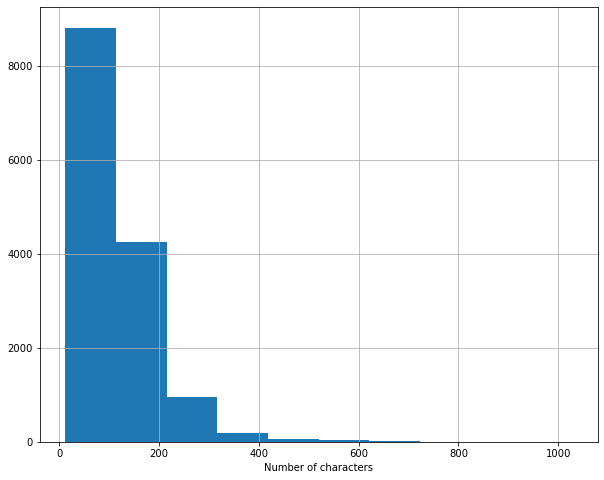

In [51]:
#Create a new column 'sentence_len'
clean_data['sentence_len'] = clean_data['clean_text'].str.len()
print('Max length: {}, Min length: {}, Average Length :  {}'.format(max(clean_data['sentence_len']),
                                            min(clean_data['sentence_len']), round(clean_data['sentence_len'].mean(), 0)))

#Visualize number of characters in all rows (i.e. sentences)
plt.figure(figsize = (10,8))
clean_data['sentence_len'].hist()
plt.xlabel('Number of characters')
plt.show()

### Comments:
- We can see that sentences range from 12 to 1028 characters.  
- Majority of sentences are approximately between 12 and 200 characters.  

### * Word-level analysis 

Max_word_count: 161, Min_word_count: 3, Average_word_count:  15.0


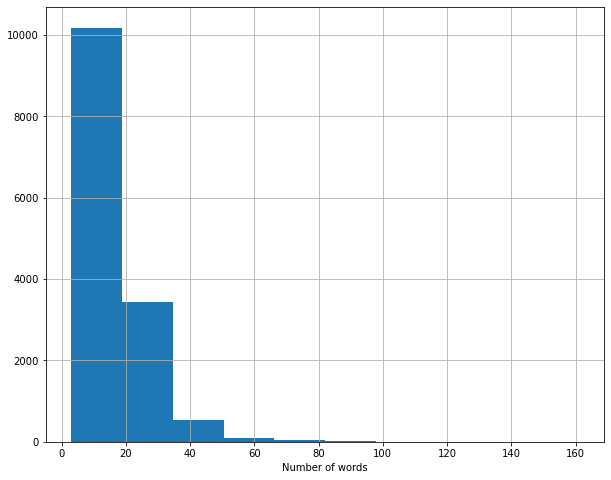

In [52]:
#Create a new column 'word_count'
clean_data['word_count'] = clean_data['clean_text'].str.split().map(lambda x: len(x))
print('Max_word_count: {}, Min_word_count: {}, Average_word_count:  {}'.format(max(clean_data['word_count']),
                                        min(clean_data['word_count']), round(clean_data['word_count'].mean(), 0)))

#Visualize number of words in all sentences
plt.figure(figsize = (10,8))
clean_data['word_count'].hist()
plt.xlabel('Number of words')
plt.show()

### Comments:
- It is clear that number of words in each sentence range from 3 to 161.  
- Most of sentences have a total word count of 3 to 34 as shown in the above chart.  

In [53]:
#Determine the most common words (which is the highest frequencies)
#Create list of words for the entire document in the column 'clean_text'
all_text = ' '.join(t for t in clean_data['clean_text'])
words_list = all_text.split()

#Create a dictionary of words
word_freq = {}
for word in set(words_list):
    word_freq[word] = words_list.count(word)

#Creating dataframe of words
df_word = pd.DataFrame(word_freq.items(),columns=['word','count'])
df_word['word_len'] = df_word['word'].map(lambda x: len(x))

#Sorting values 
df_word = df_word.sort_values('count', ascending=False).reset_index(drop=True)
df_word.head(10)

,word,count,word_len
0,one,1861,3
1,would,1311,5
2,may,1084,3
3,time,883,4
4,specie,805,6
5,two,800,3
6,great,786,5
7,said,727,4
8,bird,704,4
9,many,683,4


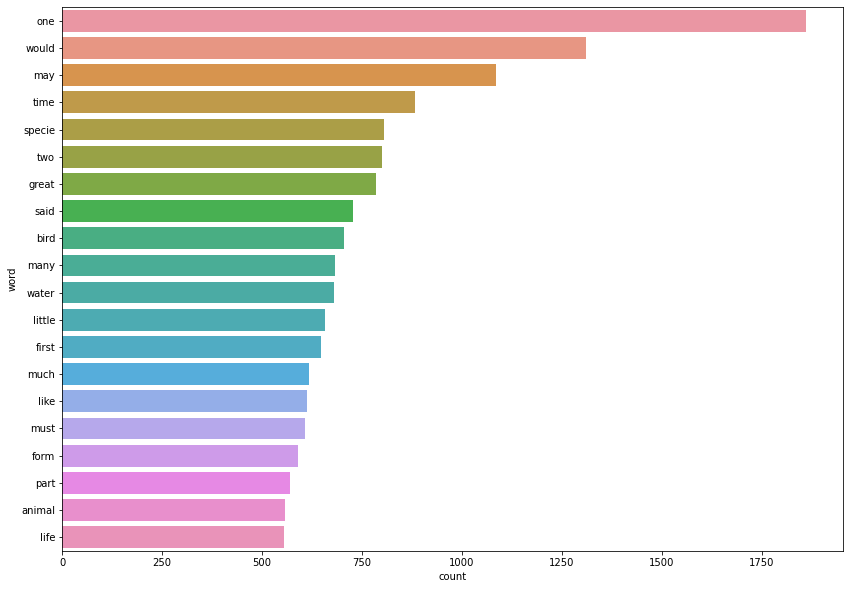

In [54]:
#Display the 20 most common words
plt.figure(figsize = (14,10))
sb.barplot(df_word['count'][:20],df_word['word'][:20])
plt.show()

In [154]:
#WordCloud to determine which words representing the text corpus of the whole document
#Generate word cloud for all texts
import PIL
from PIL import Image, ImageDraw, ImageFont
from io import BytesIO
from wordcloud import STOPWORDS, ImageColorGenerator
word_cloud = WordCloud(background_color = 'black', max_words=200, max_font_size=150,
                      width = 1600, height = 800, random_state = 42).generate(all_text)
#Show the word cloud
plt.figure(figsize=(14,16))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show

ValueError: Only supported for TrueType fonts

In [141]:
import PIL

### Comments:
- We can see obviously that the most common words such as 'one','may','time','great' so on with the highest frequencies (number of counts) in the bar chart will appear in the biggest size in the word cloud.

### * Sentiment Analysis

In [58]:
#Define a function to compute 'polarity score'
def polarity_score(text):
    return TextBlob(text).sentiment.polarity

#Define a function to determine types of polarity
def sentiment(score):
    if score < 0:
        return 'negative'
    elif score == 0:
        return 'neutral'
    else:
        return 'positive'

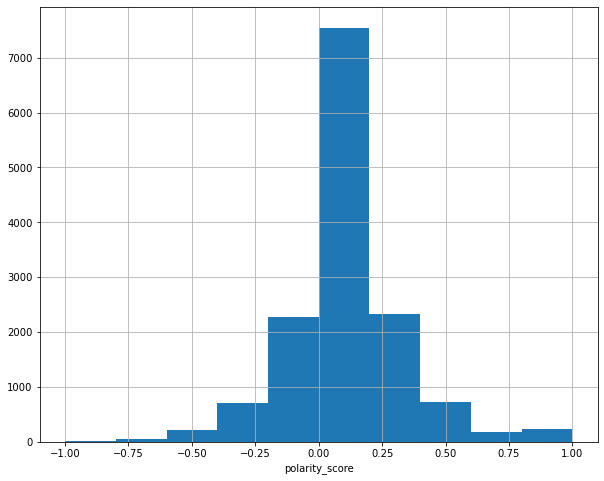

In [59]:
#Determine polarity score of the entire document
#Create a new column 'polarity score'
clean_data['polarity_score'] = clean_data['clean_text'].apply(lambda x : polarity_score(x))

#Visualize
plt.figure(figsize = (10,8))
clean_data['polarity_score'].hist()
plt.xlabel('polarity_score')
plt.show()

### Comments:
You can see that the polarity score mainly ranges between 0.00 and 0.20. This means that the majority of texts are neutral.  

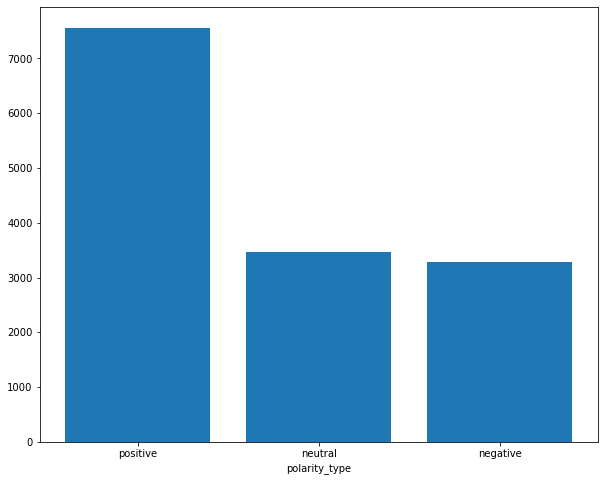

In [60]:
#Deeper classifying the texts as negative, positive and neutral based on the scores
#Create a new column 'polarity type'
clean_data['polarity_type'] = clean_data['polarity_score'].map(lambda x: sentiment(x))

#Visualize
plt.figure(figsize = (10,8))
plt.bar(clean_data.polarity_type.value_counts().index, clean_data.polarity_type.value_counts())
plt.xlabel('polarity_type')
plt.show()

### Comments:
It is clearly that majority of sentences are 'neutral' and 'positive', which is more than twice as many as 'negative'.  

In [70]:
#Compute accuracies for all algorithms
cv_df = compute_models(X,y)

Scores of test dataset:
LogisticRegression [0.7934288710241174, 0.7934288710241174, 0.7934288710241174]
Scores of test dataset:
DecisionTreeClassifier [0.6413841314225796, 0.6438308283816847, 0.6494232785739252]
Scores of test dataset:
RandomForestClassifier [0.7098916462775253, 0.7095421181405103, 0.7042991960852849]
Scores of test dataset:
GradientBoostingClassifier [0.6060817895840616, 0.6060817895840616, 0.6064313177210765]
Scores of test dataset:
MultinomialNB [0.823138762670395, 0.823138762670395, 0.823138762670395]


In [71]:
#compare all algorithms using accuracy, gini and computation time
cv_df

,model_name,score_train_mean,score_test_mean,abs|score|,gini_mean,time_mean
0,LogisticRegression,0.954037,0.793429,0.160608,0.951201,622.066667
1,DecisionTreeClassifier,0.994408,0.644879,0.349528,0.630132,563.000000
2,RandomForestClassifier,0.990446,0.707911,0.282535,0.866747,693.533333
3,GradientBoostingClassifier,0.627403,0.606198,0.021205,0.793010,368.800000
4,MultinomialNB,0.873558,0.823139,0.050419,0.960002,331.033333


### Comments:
We can see that model 'MultinomialNB' has the highest Gini value (0.96) with the shortest time compared to the other models. Therefore, we will choose this model to compute later.

In [72]:
#Split the full dataset into train and test sets according to the ratio 80:20
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [73]:
#We use the algorithm Multinomial Naive Bayes to build model
multi_nb_instance = MultinomialNB()

In [74]:
#Fit the model with train dataset
multi_nb_model = multi_nb_instance.fit(X_train_c, y_train_c)

In [75]:
#We use R2 score to check whether the model is overfitting or underfitting
print('R2 score of train dataset: ', multi_nb_model.score(X_train_c, y_train_c))
print('R2 score of test dataset: ', multi_nb_model.score(X_test_c, y_test_c))

R2 score of train dataset:  0.873558196434813
R2 score of test dataset:  0.823138762670395


In [76]:
#Compute the prediction based on 'X_test'
y_pred_c = multi_nb_model.predict(X_test_c)

In [77]:
#Compute accuracy and AUC of the model
accuracy_c = accuracy_score(y_test_c, y_pred_c)
y_prob_c = multi_nb_model.predict_proba(X_test_c)
auc_c = roc_auc_score(y_test_c, y_prob_c, multi_class = 'ovr')
print('Accuracy of the model is:', round(accuracy_c,2))
print("Auc of the model is:", round(auc_c,2))

Accuracy of the model is: 0.82
Auc of the model is: 0.98


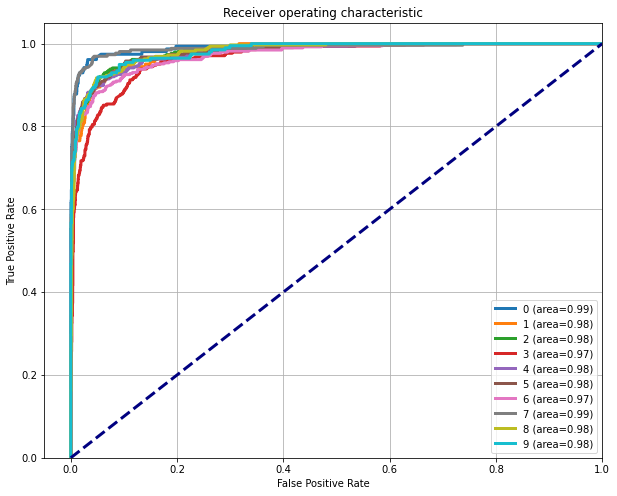

In [78]:
# Plot ROC
fig, ax = plt.subplots(figsize=(10,8))
classes = np.unique(y_test_c)  #or can use y_train_c
y_test_c_array = pd.get_dummies(y_test_c, drop_first = False).values
for i in range(len(classes)):
    fpr, tpr, thresholds = roc_curve(y_test_c_array[:,i], y_prob_c[:,i])
    ax.plot(fpr, tpr, lw=3, label='{0} (area={1:0.2f})'.format(classes[i], auc(fpr, tpr)))
    
ax.plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax.set(xlim=[-0.05,1.0], ylim=[0.0,1.05], xlabel='False Positive Rate',
                                    ylabel="True Positive Rate", title="Receiver operating characteristic")
ax.legend(loc="lower right")
ax.grid(True)
plt.show()

In [79]:
#Print confusion matrix
confusion_matrix(y_test_c, y_pred_c)

array([[142,   0,   2,   6,   0,   2,   0,   0,   4,   0],
       [  1, 122,  12,   2,   1,   1,   3,   2,   5,  13],
       [  3,   3, 275,  10,   6,  14,   8,   2,  11,   9],
       [ 19,   0,   7, 258,   6,   6,  25,   2,  15,   5],
       [  4,   1,   5,   9, 310,   4,  24,   9,   6,   3],
       [  8,   1,   4,  15,   2, 255,   6,   4,  12,   2],
       [  1,   2,   4,  16,   9,   7, 326,   3,   8,  12],
       [  0,   3,   4,   3,   5,   3,   3, 235,   4,   2],
       [  5,   2,   4,  13,   7,   8,   6,   1, 269,  11],
       [  1,  10,   3,   4,   2,   2,   4,   0,  10, 163]], dtype=int64)

In [80]:
#Print classification report
print(classification_report(y_test_c, y_pred_c, target_names = author_list))

                    precision    recall  f1-score   support

     Lewis Carroll       0.77      0.91      0.84       156
 Thomas E. Willson       0.85      0.75      0.80       162
Camille Flammarion       0.86      0.81      0.83       341
      W. H. Hudson       0.77      0.75      0.76       343
   Robert Jennings       0.89      0.83      0.86       375
 Luella Agnes Owen       0.84      0.83      0.83       309
    Charles Darwin       0.80      0.84      0.82       388
      Watson Smith       0.91      0.90      0.90       262
    Walter Bagehot       0.78      0.83      0.80       326
   Three Initiates       0.74      0.82      0.78       199

          accuracy                           0.82      2861
         macro avg       0.82      0.83      0.82      2861
      weighted avg       0.83      0.82      0.82      2861



In [81]:
#Save the model with tfidf technique
pickle.dump(multi_nb_model, open("NLP_model/bow_multinb_model.pickle","wb"))

### Comments:
- With the Bags-of-Words technique, the model MultinomialNB obtains good performance. The model is neither overfitting nor underfitting.  
- The model achieves good results, which has accuracy of 0.82 and AUC value of 0.98.

## 4. Similar to 3., but using TF-IDF

In [82]:
#Create a Tf-idf Vectorizer instance
tfidf_vec = TfidfVectorizer(stop_words = 'english', max_features=2000)

In [83]:
#Fit the full data
tfidf_vec.fit(source_text)

TfidfVectorizer(max_features=2000, stop_words='english')

In [84]:
#Transform source text array into a sparse numeric matrix
tfidf_matrix = tfidf_vec.transform(source_text)
tfidf_matrix

<14305x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 125986 stored elements in Compressed Sparse Row format>

In [85]:
#Then convert it into a numeric array X
X = tfidf_matrix.toarray()
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [86]:
#Split the full dataset into train and test sets according to the ratio 80:20
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [87]:
#We use the algorithm Multinomial Naive Bayes to build model
tfidf_multi_nb = MultinomialNB()

In [88]:
#Fit the model with train dataset
tfidf_multinb_model = tfidf_multi_nb.fit(X_train_t, y_train_t)

In [89]:
#We use R2 score to check whether the model is overfitting or underfitting
print('R2 score of train dataset: ', tfidf_multinb_model.score(X_train_t, y_train_t))
print('R2 score of test dataset: ', tfidf_multinb_model.score(X_test_t, y_test_t))

R2 score of train dataset:  0.8719853198182453
R2 score of test dataset:  0.8189444250262146


In [90]:
#Compute the prediction
y_pred_t = tfidf_multinb_model.predict(X_test_t)

In [91]:
#Compute accuracy and AUC of the model
accuracy_t = accuracy_score(y_test_t, y_pred_t)
y_prob_t = tfidf_multinb_model.predict_proba(X_test_t)
auc_t = roc_auc_score(y_test_t, y_prob_t, multi_class = 'ovr')
gini_t = 2 * auc_t - 1
print('Accuracy of the model after using TF-IDF is:', round(accuracy_t,2))
print("Auc of the model after using TF-IDF is:", round(auc_t,2))
print("Gini of the model after using TF-IDF is:", round(gini_t,2))

Accuracy of the model after using TF-IDF is: 0.82
Auc of the model after using TF-IDF is: 0.98
Gini of the model after using TF-IDF is: 0.96


In [92]:
#Print confusion matrix
confusion_matrix(y_test_t, y_pred_t)

array([[129,   0,   2,  13,   1,   4,   0,   0,   7,   0],
       [  0, 100,  23,   3,   2,   1,   4,   4,   9,  16],
       [  1,   0, 279,  11,  10,   9,   9,   2,  12,   8],
       [  6,   0,   9, 260,   8,   6,  32,   2,  19,   1],
       [  3,   0,   5,   5, 314,   5,  25,   7,   8,   3],
       [  3,   1,   4,  15,   4, 255,   5,   4,  17,   1],
       [  1,   0,   5,  12,   6,   8, 338,   1,  12,   5],
       [  0,   1,   4,   3,   9,   3,   7, 226,   5,   4],
       [  4,   0,   4,  11,   8,   5,   9,   0, 279,   6],
       [  0,   2,   6,   5,   2,   2,   6,   0,  13, 163]], dtype=int64)

In [93]:
#Print classification report
print(classification_report(y_test_t, y_pred_t, target_names = author_list))

                    precision    recall  f1-score   support

     Lewis Carroll       0.88      0.83      0.85       156
 Thomas E. Willson       0.96      0.62      0.75       162
Camille Flammarion       0.82      0.82      0.82       341
      W. H. Hudson       0.77      0.76      0.76       343
   Robert Jennings       0.86      0.84      0.85       375
 Luella Agnes Owen       0.86      0.83      0.84       309
    Charles Darwin       0.78      0.87      0.82       388
      Watson Smith       0.92      0.86      0.89       262
    Walter Bagehot       0.73      0.86      0.79       326
   Three Initiates       0.79      0.82      0.80       199

          accuracy                           0.82      2861
         macro avg       0.84      0.81      0.82      2861
      weighted avg       0.83      0.82      0.82      2861



In [94]:
#Save the model with tfidf technique
pickle.dump(tfidf_multinb_model, open("NLP_model/tfidf_multinb_model.pickle","wb"))

### Comments:
- Compared to Bags of Words, the TF-IDF technique achieves the same AUC value (0.98), which means the same Gini value (0.96). 

## 5. Similar to 3., but using word2vec

In [95]:
#Generate a new column 'word_clean_text'
clean_data['word_clean_text'] = clean_data['clean_text'].str.split()
clean_data.head()

,clean_text,author_name,author_class,sentence_len,word_count,polarity_score,polarity_type,word_clean_text
0,rabbithole alice beginning get tired sitting s...,Lewis Carroll,0,348,50,-0.135714,negative,"[rabbithole, alice, beginning, get, tired, sit..."
1,nothing remarkable alice think much way hear r...,Lewis Carroll,0,377,54,0.194898,positive,"[nothing, remarkable, alice, think, much, way,..."
2,another moment went alice never considering wo...,Lewis Carroll,0,53,8,0.000000,neutral,"[another, moment, went, alice, never, consider..."
3,rabbithole went straight like tunnel way dippe...,Lewis Carroll,0,117,17,0.066667,positive,"[rabbithole, went, straight, like, tunnel, way..."
4,either well deep fell slowly plenty time went ...,Lewis Carroll,0,75,13,-0.100000,negative,"[either, well, deep, fell, slowly, plenty, tim..."


In [96]:
#Split the full dataset into train and test sets according to the ratio 80:20
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(clean_data['word_clean_text'], clean_data['author_class'], 
                                                                            test_size = 0.20, random_state = 42)

In [97]:
#Create the word2vec model
w2v_model = gensim.models.Word2Vec(X_train_w2v, vector_size=100, window=5, min_count=1, max_vocab_size=3000)

In [98]:
#Generate aggregated sentence vectors based on the word vectors for each word in the sentence
words_dict = set(w2v_model.wv.index_to_key)
X_train_sent = np.array([np.array([w2v_model.wv[i] for i in ls if i in words_dict]) for ls in X_train_w2v])
X_test_sent = np.array([np.array([w2v_model.wv[i] for i in ls if i in words_dict]) for ls in X_test_w2v])

In [99]:
# Compute average sentence vectors by averaging the word vectors for the words contained in the sentence
X_train_sent_avg = []
for v in X_train_sent:
    if v.size:
        X_train_sent_avg.append(v.mean(axis=0))
    else:
        X_train_sent_avg.append(np.zeros(100, dtype=float))
        
X_test_sent_avg = []
for v in X_test_sent:
    if v.size:
        X_test_sent_avg.append(v.mean(axis=0))
    else:
        X_test_sent_avg.append(np.zeros(100, dtype=float))

In [100]:
#In this case, we use Random Forest instead of Multinomial Naive Bayes to build model
#because MultinomialNB does not support with negative values
w2v_rfc = RandomForestClassifier(n_estimators=100)

In [101]:
#Fit the model with train dataset
w2v_rfc_model = w2v_rfc.fit(X_train_sent_avg, y_train_w2v)

In [102]:
# Use the trained model to make predictions on the test data
y_pred_w2v = w2v_rfc_model.predict(X_test_sent_avg)

In [103]:
#Compute accuracy and AUC and Gini of the model
accuracy_w2v = accuracy_score(y_test_w2v, y_pred_w2v)
y_prob_w2v = w2v_rfc_model.predict_proba(X_test_sent_avg)
auc_w2v = roc_auc_score(y_test_w2v, y_prob_w2v, multi_class = 'ovr')
gini_w2v = 2 * auc_w2v - 1
print('Accuracy of the model after using word2vec is:', round(accuracy_w2v,2))
print("Auc of the model after using word2vec is:", round(auc_w2v,2))
print("Gini of the model after using word2vec is:", round(gini_w2v,2))

Accuracy of the model after using word2vec is: 0.63
Auc of the model after using word2vec is: 0.91
Gini of the model after using word2vec is: 0.82


In [104]:
#Print confusion matrix
confusion_matrix(y_test_w2v, y_pred_w2v)

array([[110,   0,   6,  20,   2,   4,   2,   1,   9,   2],
       [  1,  76,  31,   7,   1,   6,   3,   2,  14,  21],
       [  1,   9, 235,  20,  19,  17,   5,   6,  15,  14],
       [  9,   1,  15, 143,  25,  26,  54,   2,  53,  15],
       [  1,   3,  20,  17, 242,  16,  28,  15,  29,   4],
       [  2,   3,  16,  28,  13, 201,   9,  15,  16,   6],
       [  1,   1,  14,  27,  36,  14, 242,   3,  35,  15],
       [  0,   1,   3,   5,  19,  12,   3, 203,   9,   7],
       [ 10,   3,  14,  21,  18,  10,  17,   1, 213,  19],
       [  0,  10,  10,   6,   6,   2,   2,   1,  31, 131]], dtype=int64)

In [105]:
#Print classification report
print(classification_report(y_test_w2v, y_pred_w2v, target_names = author_list))

                    precision    recall  f1-score   support

     Lewis Carroll       0.81      0.71      0.76       156
 Thomas E. Willson       0.71      0.47      0.57       162
Camille Flammarion       0.65      0.69      0.67       341
      W. H. Hudson       0.49      0.42      0.45       343
   Robert Jennings       0.64      0.65      0.64       375
 Luella Agnes Owen       0.65      0.65      0.65       309
    Charles Darwin       0.66      0.62      0.64       388
      Watson Smith       0.82      0.77      0.79       262
    Walter Bagehot       0.50      0.65      0.57       326
   Three Initiates       0.56      0.66      0.61       199

          accuracy                           0.63      2861
         macro avg       0.65      0.63      0.63      2861
      weighted avg       0.63      0.63      0.63      2861



In [106]:
#Save the model with word2vec technique
pickle.dump(w2v_rfc_model, open("NLP_model/w2v_rfc_model.pickle","wb"))

### Comments:
- This Word2Vec technique obtains lower AUC value (0.91) than that of Bags of Words and TF-IDF techniques (which have AUC value of 0.98).

## 6. Appy RNN to do classification

In [107]:
#Show the clean data for quick reference
clean_data.head()

,clean_text,author_name,author_class,sentence_len,word_count,polarity_score,polarity_type,word_clean_text
0,rabbithole alice beginning get tired sitting s...,Lewis Carroll,0,348,50,-0.135714,negative,"[rabbithole, alice, beginning, get, tired, sit..."
1,nothing remarkable alice think much way hear r...,Lewis Carroll,0,377,54,0.194898,positive,"[nothing, remarkable, alice, think, much, way,..."
2,another moment went alice never considering wo...,Lewis Carroll,0,53,8,0.000000,neutral,"[another, moment, went, alice, never, consider..."
3,rabbithole went straight like tunnel way dippe...,Lewis Carroll,0,117,17,0.066667,positive,"[rabbithole, went, straight, like, tunnel, way..."
4,either well deep fell slowly plenty time went ...,Lewis Carroll,0,75,13,-0.100000,negative,"[either, well, deep, fell, slowly, plenty, tim..."


In [108]:
#Create the input and output datasets
X_rnn = clean_data['clean_text']
y_rnn = clean_data['author_class']    
y_rnn = np_utils.to_categorical(y_rnn) 

In [109]:
#Split the full dataset into train and test sets according to the ratio 80:20
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_rnn, y_rnn, test_size = 0.20, random_state = 42)

In [110]:
#Normalizing texts of the whole document
max_words = 1000 
max_len = 100 

tok = Tokenizer(num_words = max_words)
tok.fit_on_texts(X_train_r)

sequences = tok.texts_to_sequences(X_train_r)
sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_len)

In [111]:
print(sequences[:2])

[[697, 245, 741, 11, 135, 5, 199, 135, 612, 351, 376, 612, 97, 163, 351, 376, 1, 259], [59, 60, 133, 885]]


In [112]:
#Create a deep learning network - RNN
rnn_model = Sequential()
rnn_model.add(Embedding(max_words, 800))
rnn_model.add(Dropout(0.7))
rnn_model.add(LSTM(64))
rnn_model.add(Dropout(0.7))
rnn_model.add(Dense(256, activation='relu')) 
rnn_model.add(Dropout(0.7))
rnn_model.add(Dense(10, activation='softmax'))

In [113]:
#Compile the model
rnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [114]:
#Summary of the model
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 800)         800000    
                                                                 
 dropout (Dropout)           (None, None, 800)         0         
                                                                 
 lstm (LSTM)                 (None, 64)                221440    
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 256)               16640     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


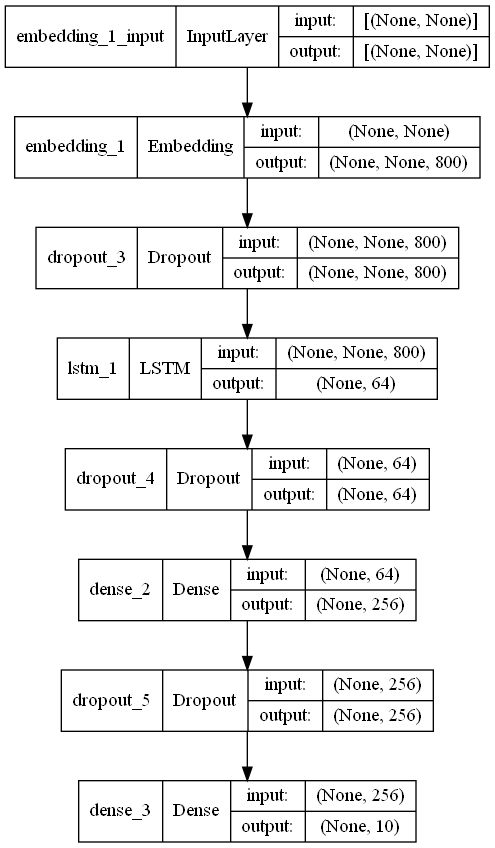

In [115]:
#Model diagram for reference
plot_model(rnn_model, to_file='RNN_model/Gutenberg_RNN_NLP_model_29052022.png', show_shapes=True)
Image(filename='RNN_model/Gutenberg_RNN_NLP_model_29052022.png')

In [116]:
# Create callback to make early stopping
callbacks = [EarlyStopping(monitor='val_loss', 
                      patience=5, 
                      mode='auto')
]

In [117]:
#Fit the model
history = rnn_model.fit(sequences_matrix, y_train_r,
                    batch_size=32,             
                    epochs=1,
                    validation_split=0.2,
                    verbose = 0,
                    callbacks=callbacks,
                   )

       loss  accuracy  val_loss  val_accuracy
0  1.990929  0.281267  1.252336        0.6173


<AxesSubplot:>

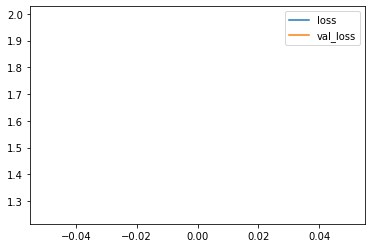

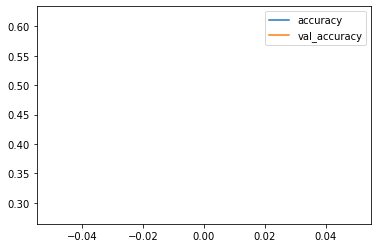

In [118]:
#Visualize 
history_df = pd.DataFrame(history.history)
print(history_df.tail())
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()

### Comments:
- After the training stage, we can see that the val loss of validation dataset and loss of train dataset are small and close together meanwhile accuracies of validation and train dataset increase and remain stable at high value.  
- We use Early Stopping to prevent the model from increasing val_loss and loss again.

In [119]:
#Evaluate the model based on test dataset
test_sequences = tok.texts_to_sequences(X_test_r)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [120]:
#Tính accuracy của model
acc_rnn = rnn_model.evaluate(test_sequences_matrix, y_test_r)

90/90 [==============================] - 3s 36ms/step - loss: 1.2673 - accuracy: 0.6194


In [121]:
#Save the model
rnn_model.save('RNN_model/Gutenberg_RNN_NLP_29052022.h5')
print('save!!!')

save!!!


In [122]:
#Compute the prediction values
y_pred_r = rnn_model.predict(test_sequences_matrix)
#Get max value for each class
y_pred_r = np.argmax(y_pred_r, axis=-1)
y_test_rnn = np.argmax(y_test_r, axis=-1)

90/90 [==============================] - 4s 36ms/step


In [123]:
#Confusion matrix
cm = confusion_matrix(y_test_rnn, y_pred_r)
cm

array([[106,   0,   2,  10,   1,  14,   7,   0,  16,   0],
       [  4,  17,  46,   4,   1,  50,   1,   7,  18,  14],
       [  0,   0, 240,   1,  18,  12,   8,   8,  51,   3],
       [ 10,   0,   8, 155,  14,  30,  57,   1,  64,   4],
       [  0,   0,   7,   5, 248,  12,  66,  11,  25,   1],
       [  4,   0,   8,  12,  20, 207,  23,  14,  20,   1],
       [  1,   1,   2,  16,  22,   8, 317,   0,  20,   1],
       [  2,   0,   4,   2,  25,  38,   5, 174,  12,   0],
       [  4,   0,   8,  17,  14,  10,  16,   0, 254,   3],
       [  7,   3,   3,  18,  12,  55,  12,   1,  34,  54]], dtype=int64)

In [124]:
#Print Classification Report
print(classification_report(y_test_rnn, y_pred_r, target_names=author_list))

                    precision    recall  f1-score   support

     Lewis Carroll       0.77      0.68      0.72       156
 Thomas E. Willson       0.81      0.10      0.19       162
Camille Flammarion       0.73      0.70      0.72       341
      W. H. Hudson       0.65      0.45      0.53       343
   Robert Jennings       0.66      0.66      0.66       375
 Luella Agnes Owen       0.47      0.67      0.56       309
    Charles Darwin       0.62      0.82      0.70       388
      Watson Smith       0.81      0.66      0.73       262
    Walter Bagehot       0.49      0.78      0.60       326
   Three Initiates       0.67      0.27      0.39       199

          accuracy                           0.62      2861
         macro avg       0.67      0.58      0.58      2861
      weighted avg       0.65      0.62      0.60      2861



## 7. Using unsupervised technique, visualize bar graphs for clusters containing 10 author documents. Adjust by silhouette scores.  
- For clustering, we will use the text dataset after being processed by TF-IDF with max_features = 2000.  
- Use algorithms like KMeans, GMM to find optimal number of clusters via silhouette scores or elbow method.  

In [125]:
#Input dataset after being processed by TF-IDF
input_dataset = tfidf_matrix.toarray()

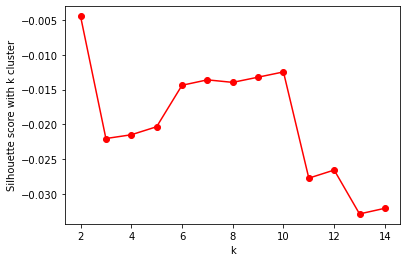

In [126]:
#Find the optimal number of clusters using silhouette score with GMM
k_range = np.arange(2,15)
sil_score = []
for k in k_range:
    cluster = GaussianMixture(n_components=k, random_state=42)
    y_pred = cluster.fit_predict(input_dataset)
    score = silhouette_score(input_dataset, y_pred)
    sil_score.append(score)

plt.plot(k_range, sil_score, 'ro-')
plt.xlabel('k')
plt.ylabel('Silhouette score with k cluster')
plt.show()

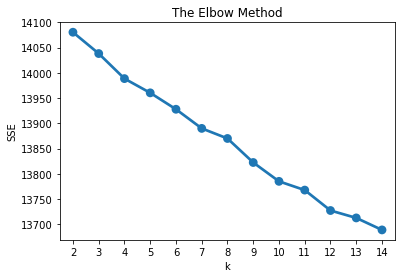

In [127]:
#Find the optimal number of clusters using Elbow Method with KMeans
sse = {}
k_range = np.arange(2,15)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(input_dataset)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid
    
#Visualize to choose k
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sb.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

### Comments:
- After using KMeans with Elbow Method or GMM algorithms with Silhouette Score, I still cannot obtain the optimal k, which is the number of clusters in this case.
- Currently, I have not found any feasible solution to solve this issue.  

## 8. Using LSA, LDA and NNMF, print out top ten words (with their highest loading) for each topic modeling. Analyze and compare among three methods.

### 8.1 LSA - Latent Semantic Analysis
- Is a popular dimensionality-reduction technique which is the same method as Singular Value Decomposition. In other words, we can address this technique as LSA or SVD.  
- It is generally implemented with Tfidf values and not with the Bags-of-Words.

In [128]:
#Create LSA model with 10 components (i.e representing 10 authors)
lsa_instance = TruncatedSVD(n_components=10, random_state=42)

In [129]:
#Transform the data after using tfidf technique
lsa_data = lsa_instance.fit_transform(tfidf_matrix)

In [130]:
#Get the 10 most important words for each latent component (indirectly representing for each author)
lsa_vocab = tfidf_vec.get_feature_names()

for i, comp in enumerate(lsa_instance.components_):
    vocab_comp = zip(lsa_vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

Topic 0: 
said time specie great bird little alice like life water 

Topic 1: 
said alice king know queen dont turtle mock went hatter 

Topic 2: 
specie variety said genus case selection natural individual character number 

Topic 3: 
plane principle mental mind matter universe law life globe atom 

Topic 4: 
water acid principle matter plane mental solution mind form great 

Topic 5: 
specie water sun acid said earth globe variety star form 

Topic 6: 
time cow milk calf acid water good day food quantity 

Topic 7: 
bird acid star like colour solution fibre little water know 

Topic 8: 
time water bird great specie house lord day law common 

Topic 9: 
great house lord star like power government selection acid common 



In [131]:
#To better visualize words in a topic, we can utilize the wordcloud and choose top 50 words for each topic
def draw_word_cloud(index, model_type):
    imp_words_topic = ""
    comp = model_type.components_[index]
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:50]
    for word in sorted_words:
        imp_words_topic=imp_words_topic + " " + word[0]

    wc = WordCloud(width=600, height=400, random_state=42).generate(imp_words_topic)
    plt.figure( figsize=(8,6))
    plt.imshow(wc)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

In [132]:
#Draw wordcloud of topic 0 with LSA technique
draw_word_cloud(0, lsa_instance)

NameError: name 'vocab' is not defined

### 8.2 LDA - Latent Dirichlet Allocation 

In [133]:
#Create LDA model with 10 components (i.e representing 10 authors)
lda_instance = LatentDirichletAllocation(n_components=10,learning_method='online',random_state=42,max_iter=5)

In [134]:
#Transform the data after using tfidf technique
lda_data = lda_instance.fit_transform(tfidf_matrix)

In [135]:
#Get the 10 most important words for each latent component (indirectly representing for each author)
lda_vocab = tfidf_vec.get_feature_names()

for i, comp in enumerate(lda_instance.components_):
    vocab_comp = zip(lda_vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

Topic 0: 
selection process breed state nation importance race good society difficult 

Topic 1: 
lord star england variation given point view rock nature ordinary 

Topic 2: 
degree mile cave scale single manifest average chamber easily globe 

Topic 3: 
said house bird foot time like seen little party specie 

Topic 4: 
specie fibre character wool used queen believe parliament doubt distinct 

Topic 5: 
case variety le solution period pole mean let seed instance 

Topic 6: 
constitution black various influence dye case opinion position soda likely 

Topic 7: 
government important cow quality cattle man general country motion region 

Topic 8: 
principle form mental plane power law mind colour matter life 

Topic 9: 
milk acid individual common salt water heat animal lower assembly 



In [136]:
#Draw wordcloud of topic 0 with LDA technique
draw_word_cloud(0, lda_instance)

NameError: name 'vocab' is not defined

### 8.3 NNMF - Non Negative Matrix Factorization

In [143]:
#Create NMF model with 10 components (i.e representing 10 authors)
nmf_instance = NMF(n_components=10, solver="mu")

In [144]:
#Transform the data after using tfidf technique
nmf_data = nmf_instance.fit_transform(tfidf_matrix)

In [145]:
#Get the 10 most important words for each latent component (indirectly representing for each author)
nmf_vocab = tfidf_vec.get_feature_names()

for i, comp in enumerate(nmf_instance.components_):
    vocab_comp = zip(nmf_vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

Topic 0: 
cow animal milk case good food year calf le selection 

Topic 1: 
said alice know king queen dont turtle mock thing went 

Topic 2: 
specie variety genus number character individual difference distinct case form 

Topic 3: 
plane principle mind matter mental law universe life vibration atom 

Topic 4: 
water acid solution colour salt fibre wool lime form iron 

Topic 5: 
sun earth star mile globe planet distance kilometer world light 

Topic 6: 
foot cave room wall long passage entrance high small chamber 

Topic 7: 
bird like little life know sound village nest come small 

Topic 8: 
time day present long half period year diameter left men 

Topic 9: 
great house lord power government common people party say english 



In [146]:
#Draw wordcloud of topic 0 with NMF technique
draw_word_cloud(0, nmf_instance)

NameError: name 'vocab' is not defined

### Comments:
- These 3 algorithms (LSA, LDA, NNMF) are usually used with TF-IDF technique.  
- LDA and NNMF algorithms are more popular than LSA.  
- NNMF provides more coherent topics and less time execution than LDA.